In [1]:
import os
import gzip
import numpy as np
import pandas as pd
import time
import datetime
import cPickle as pickle
from matplotlib.pylab import subplots
import matplotlib.pylab as mpylab
import matplotlib.ticker as mticker
import matplotlib.dates as mdates

In [2]:
def UTC_to_UnixTime(dt):
    '''
    Given a UTC time, find the Unix time

    :param dt, UTC datetime
    :type message: datetime.datetime
    :returns: Unix time of the UTC datetime, like 1200835411
    :type returns: int
    '''
    return int((dt - datetime.datetime(1970,1,1)).total_seconds())

def UnixTime_to_UTC(timestamp):

    '''
    converts Unix time to UTC time
    
    :param timestamp: unix timestamp
    :type timestamp: int 
    :return corresponding date and time
    :type: datetime.datetime
    '''
    # can show it use .strftime('%Y-%m-%d %H:%M:%S')
    return datetime.datetime.utcfromtimestamp(int(timestamp))

def find_period(UnixTime, periods):
    '''
    find the periods that UTCtime is in 
    :param UTCtime, like 1200835411
    :type message: int
    :param UTCtime, like [(start_UTCtime, end_UTCtime), ]
    :type message: int
    :returns: index of the period that UTCtime is in in periods, return -1 if cannot find a 
    period that UTCtime is in
    :type returns: int
    '''
    for i in range(len(periods)):
        if periods[i][0] <= UnixTime < periods[i][1]:
            return i
    
    # now we cannot find a period that UTCtime is in 
    return -1

In [3]:
MBID_dictionary = pickle.load(open('../Cleared Data/MBID_dictionary.p','rb'))
df_demographics = pd.read_csv('../Cleared Data/MLHD_demographics_scrobble.csv', delimiter = '\t')
df_demographics.head()

,uuid,age,country,gender,registered,firstscrobble,lastscrobble
0,dfb7ea9d-6e4f-48e4-96f6-59abcc207d55,30.0,AT,n,1035849600,1138630578,1362652343
1,a89cb9c5-ba84-424e-8950-16657bb6f7af,35.0,US,m,1035849600,1130274207,1369498564
2,dde6c339-c256-43f1-94e8-02f4043abdf9,35.0,UK,m,1035849600,1108340306,1357866969
3,44d70878-6e9a-432f-831d-179e8354f448,40.0,DK,n,1035849600,1368342035,1126011087
4,e553ab79-5e93-48fc-aa63-1c4319cafd23,NaN,SE,n,1035849600,1189263203,1357317882


In [8]:
def artists_vs_time_for_genres(genres, periods, path):
    '''
    For several genres， count the number of artists working on this genre in different periods
    
    :param genres, a list of genres selected
    :type message: list
    :param periods, a list of periods selected, with format [(datetime, datetime), ]
    :type message: list
    :param path, a string represents path to the diretory that contains user dataset 
    :type message: str
    :returns: a dictionary contains all the statistics information, with format 
    {genres: (periods, #artists)}
    :type returns: dict
    
    Global variable df_demographics and MBID_dictionary are used
    '''
    
    # data format, dictionaries: {genres: (periods, #artists)} 
    # initialization of dictionary
    statistics = {}
    for genre in genres:
        statistics[genre] = (periods, [0] * len(periods))
    
    '''
    One artist can only be counted once for one period of every genre. 
    So we use tag_added to denote whether one artist is added as an artist
    for a genre of some period
    
    tag_added has format: {genre:{artist_MBID: list of booleans}, }
    tag_added[genre][artis_MBID][i] == True indicates that artist indentified by
    artist_MBID has been added as an artist for genre for periods[i]. 
    False indicates hasn't been added.
    '''
    tag_added = {}
    for genre in genres:
        tag_added[genre] = {}

    # number of files we go through
    for filename in os.listdir(path): # iterate over all user files
        # user file has file name: uuid.txt.gz
        if 'gz' in filename:
            with gzip.open(path + '/' + filename) as f:
                # clearing the data
                user = pd.read_csv(f, delimiter = '\t', header = None)
                user = user.drop([2,3],axis=1) 
                user = user.dropna()
                user.columns = ['time', 'artist_MBID']

                '''
                user_used is a boolean indicating whether we use this user to do statistics.
                Because the data of user is obtained in different time periods, we need to
                ensure that in the periods we used to do statistics, the user is continuing to
                contribute data to our dataset. In other words, periods should lie in 
                (time of user's firstscrobble, time of user's last scrobble)
                '''
                user_uuid = filename[:-7]
                user_demographics = df_demographics[df_demographics.uuid == user_uuid]
                user_used = False
                if user_demographics.shape[0] > 0: # if the user has demographics
                    user_used = user_demographics.iat[0,5] <= periods[0][0] \
                        and user_demographics.iat[0,6] >= periods[len(periods) - 1][1]

                for i in range(user.shape[0]): #iterate all logs in one user file
                    if user_used:
                        period_index = find_period(user.iat[i,0], periods)
                        if  period_index != -1:
                            if user.iat[i,1] in MBID_dictionary:
                                taglist = MBID_dictionary[user.iat[i,1]]
                                for tag in taglist: 
                                    for genre in genres:
                                        # tag can be something like 'hardrock' and 'pop/rock'
                                        if genre in tag:
                                            if user.iat[i,1] not in tag_added[genre]:
                                                tag_added[genre][user.iat[i,1]] = [False] * len(periods)
                                                tag_added[genre][user.iat[i,1]][period_index] = True
                                                statistics[genre][1][period_index] += 1
                                            else:
                                                if not tag_added[genre][user.iat[i,1]][period_index]:
                                                    tag_added[genre][user.iat[i,1]][period_index] = True
                                                    statistics[genre][1][period_index] += 1
    return statistics

In [14]:
def plot_artists_vs_time_for_genres(statistics, genres, datemin, datemax):
    '''
    User statistical information produced in statistics_5(genres, periods, path) 
    and plot correspoding graph, for several genres，the number of artists vs period
    
    :param statistics, the output of statistics_5(genres, periods, path), a dictionary of
    format: {genres: (periods, #artists)}
    :type statistics: dict
    :param genres, a list of genres selected to plot graph
    :type genres: list
    :param datemin, the small bound of x we plot
    :type message: datetime.datetime
    :param datemax, the large bound of x we plot
    :type message: datetime.datetime
    :returns: no return
    
    '''
    
    years = mdates.YearLocator()   # every year
    months = mdates.MonthLocator()  # every month
    yearsFmt = mdates.DateFormatter('%Y')
    
    fig,ax = subplots()
    for genre in genres:
        dates = [UnixTime_to_UTC(period[0]) for period in statistics[genre][0]]
        ax.plot(dates,statistics[genre][1], label = genre)


    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set_xlabel('date')
    ax.set_ylabel('number of artists')
    ax.set_title('number of artists vs date for different genres', fontsize=14)
    ax.set_xlim(datemin, datemax)

    # format the ticks
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(yearsFmt)
    ax.xaxis.set_minor_locator(months)
    ax.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))
    
    ax.grid(True)

    # rotates and right aligns the x labels, and moves the bottom of the
    # axes up to make room for them
    fig.autofmt_xdate()

    fig.show()
    mpylab.savefig('../Images/artists_vs_time_for_genres_(%d,%d).png' \
                   %(datemin.year,datemax.year), bbox_inches='tight')
    #print statistics5['pop']

In [9]:
'''
Plot how number of artists change with time for selected genres.
We use 1000 user files and one month as the time period. Besides,
the whole period (2008-01-01, 2012-12-1) is selected empirically. 

When you run codes, please change path, which is the local directory 
that you store user tar file, i.e. 'MLHD_000.tar'
'''
path = '/Users/yjt/Downloads'

# first select point-in-time and transfer them to unix times
selected_datetimes = []
for i in range(5):
    for j in range(12):
        selected_datetimes.append(datetime.datetime(2008 + i, j + 1, 1))
UnixTimes = [UTC_to_UnixTime(dt) for dt in selected_datetimes]

# periods = [(start_UnixTime, end_UnixTime)]
# then form periods
periods = []
for i in range(len(UnixTimes) - 1):
    periods.append((UnixTimes[i], UnixTimes[i + 1])) 
    
genres = ['pop', 'rock', 'jazz', 'folk', 'blue', 'kpop', 'hiphop', 'disco'] # list of genres
user_file_path = path + '/MLHD_000'

start_time = time.time()
statistics = artists_vs_time_for_genres(genres, periods, user_file_path)
print("--- %s seconds ---" % (time.time() - start_time))

--- 1586.40837502 seconds ---


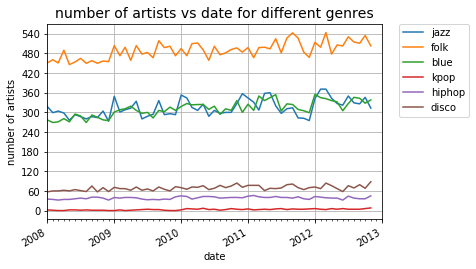

In [18]:
datemin = datetime.datetime(2008, 1, 1)
datemax = datetime.datetime(2013, 1, 1)
selected_genres = ['jazz', 'folk', 'blue', 'kpop', 'hiphop', 'disco']
plot_artists_vs_time_for_genres(statistics, selected_genres, datemin, datemax)

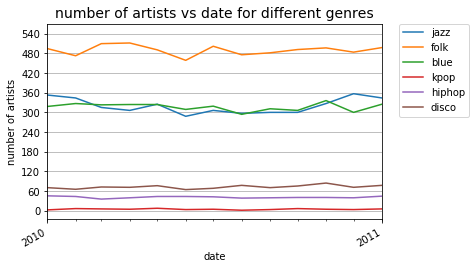

In [21]:
datemin = datetime.datetime(2010, 1, 1)
datemax = datetime.datetime(2011, 1, 1)
selected_genres = ['jazz', 'folk', 'blue', 'kpop', 'hiphop', 'disco']
plot_artists_vs_time_for_genres(statistics, selected_genres, datemin, datemax)